<a href="https://colab.research.google.com/github/typewriter221/MIDAS-CNN-Task/blob/main/MIDAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read Me
[Drive Link](https://drive.google.com/drive/folders/14jQQeZU581N7suwzgc5DXBfIK-4t_LrK?usp=sharing) contains the data converted into csv format and save Checkpoints in Checkpoint folder and the Best Model of each task in Models Folder.

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import walk
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

print(len(LABELS))

62


In [4]:
lables = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [5]:
# Confusion Matrix
def plot_confusion_matrix(model, x, y, lables = LABELS): 
  # y_test = [] 
  # y_preds = [] 
  # for imgs, labels in : 
  #   y_test.extend(np.argmax(labels, axis=1)) 
  #   y_pred = model.predict(imgs) 
  #   y_preds.extend(np.argmax(y_pred, axis=1))
  y_preds = model.predict(x)
  y_preds = np.argmax(y_preds, axis=1)

  cm = confusion_matrix(y_true = y, y_pred = y_preds) 
  cm_normalize = normalize(cm, axis=1)

  plt.figure(figsize=(15,15)); 
  sns.heatmap(cm_normalize, annot=False, xticklabels=lables, yticklabels=lables, linewidths=.1);

  plt.savefig('confusion_matrix.png', bbox_inches='tight')

#Load data in CSV Format



In [ ]:

images = []
def loadMIDAS(path,filenames, lable):
  for f in filenames:
    f = path+"/"+f
    image = [lable]
    temp = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(temp, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(im_bw,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(lable, f)
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    copy = im_bw[y:y+h, x:x+w]
    copy = cv2.resize(copy, (28,28))
    img = list(copy.flatten())
    image = image + img
    images.append(image)
  return 
location = "/content/drive/MyDrive/Colab Notebooks/MIDAS/train/Sample0"

for id in range(1,63):
  if id < 10:
    myPath = location + "0" + str(id)
  else :
    myPath = location + str(id)
  dump1, dump2, filenames = next(walk(myPath))
  loadMIDAS(myPath, filenames, id-1)

outf = "/content/drive/MyDrive/Colab Notebooks/MIDAS/train.csv"
o = open(outf, "w")
for image in images:
  o.write(",".join(str(pix) for pix in image)+"\n")
o.close()

In [10]:
# load data from csv
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIDAS/train.csv", header=None)
X = train.iloc[:,1:].values
X = X.reshape((-1,28,28))
Y = train.iloc[:,0].values


##Lable Encode 

In [11]:
#One Hot encode Lables
enc = OneHotEncoder()
Y_enc = enc.fit_transform(Y.reshape(-1,1)).toarray()

#Validation Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split( X, Y_enc, test_size=0.1, random_state=42)

#Data Augmentation


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)
datagen.fit(X_train.reshape(-1,28,28,1))

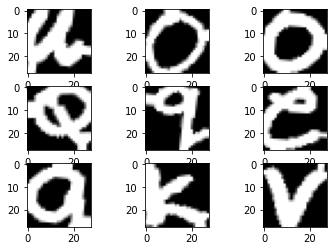

In [ ]:
for X_batch, y_batch in datagen.flow(X_train.reshape((-1,28,28,1)), y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

#Task-1


##Model



In [23]:
# Model inspired from VGG16 model
#Model overfitting adding Dropout of 0.5 after each block
# Reducing Dropout Rate from 0.5 to 0.2
# Increasing dropuout of intial layers from 0.2 to 0.4
def CNN():
  inputs = Input(shape=(28,28,1))
  x = Conv2D(75,(3,3),strides=1,padding='same',activation='swish')(inputs)
  x = Conv2D(150,(7,7),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  x = Dropout(0.5)(x)

  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  x = Dropout(0.4)(x)

  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  x = Dropout(0.2)(x)

  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  x = Dropout(0.2)(x)

  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(25,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((1,1), strides = 2 , padding = 'same')(x)

  x = Flatten()(x)

  x = Dense(256, activation='swish')(x)# Changing from sigmoid to swish Step-7
  x = BatchNormalization()(x)# Sigmoid Step-8
  x = Dropout(0.2)(x)
  x = Dense(128, activation='swish')(x)# Replacing Relu with Swish Step-4
  x = BatchNormalization()(x)
  x = Dense(128, activation='swish')(x)# Replacing Relu with Swish Step-4
  x = Dropout(0.1)(x) # Addind Dropout Step-2
  x = BatchNormalization()(x)
  x = Dense(128, activation='relu')(x)# Replacing Relu with Swish Step-4, Changing back to Relu Step-8
  
  outputs = Dense(len(LABELS), activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  # model.summary()
  return model

#Model Callbacks
Early Stopping, Learning Rate Scheduler and Checkpoint Saving

In [16]:
#Early Stopping
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, verbose=0, mode='auto', restore_best_weights=True
) # Step-1 Reduce patince from 5 to 3
#Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 5:  
    return lr
  else:
    return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#Saving model CheckPoints
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-1/task-1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
#Training on split Train Dataset
model = CNN()

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)#Increasing Learning Rate after adding dropout

# compile
model.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])
# fit
history = model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs = 200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback])

Epoch 1/200
70/70 [==============================] - 6s 32ms/step - loss: 4.2512 - acc: 0.0222 - val_loss: 16.2643 - val_acc: 0.0121
Epoch 2/200
70/70 [==============================] - 2s 21ms/step - loss: 3.5168 - acc: 0.0906 - val_loss: 6.2442 - val_acc: 0.0202
Epoch 3/200
70/70 [==============================] - 2s 21ms/step - loss: 2.9661 - acc: 0.1442 - val_loss: 4.9981 - val_acc: 0.0282
Epoch 4/200
70/70 [==============================] - 1s 21ms/step - loss: 2.6724 - acc: 0.2194 - val_loss: 3.0937 - val_acc: 0.1613
Epoch 5/200
70/70 [==============================] - 1s 21ms/step - loss: 2.2891 - acc: 0.2943 - val_loss: 4.0537 - val_acc: 0.1452
Epoch 6/200
70/70 [==============================] - 1s 21ms/step - loss: 2.0099 - acc: 0.3781 - val_loss: 2.5188 - val_acc: 0.2500
Epoch 7/200
70/70 [==============================] - 1s 21ms/step - loss: 1.7436 - acc: 0.4156 - val_loss: 1.8681 - val_acc: 0.4073
Epoch 8/200
70/70 [==============================] - 1s 21ms/step - loss: 1

In [ ]:
#Training on complete dataset
model = CNN()

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile
model.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])
#fit
# The model reached saturation after 12 epochs on validation data, the model was overfitting adding Dropout Regularization to the model  
# Using augmented data for validation set
history2 = model.fit(X,Y_enc,validation_data = datagen.flow(X_train.reshape((-1,28,28,1)),y_train,batch_size=3000),epochs = 200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback])

Epoch 1/200
78/78 [==============================] - 7s 70ms/step - loss: 4.2176 - acc: 0.0353 - val_loss: 14.1159 - val_acc: 0.0175
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-1/task-1/assets
Epoch 2/200
78/78 [==============================] - 2s 32ms/step - loss: 3.2283 - acc: 0.1389 - val_loss: 11.8311 - val_acc: 0.0202
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-1/task-1/assets
Epoch 3/200
78/78 [==============================] - 2s 31ms/step - loss: 2.4894 - acc: 0.2725 - val_loss: 5.5316 - val_acc: 0.0865
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-1/task-1/assets
Epoch 4/200
78/78 [==============================] - 2s 32ms/step - loss: 2.1360 - acc: 0.3271 - val_loss: 3.0257 - val_acc: 0.2249
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-1/task-1/assets
Epoch 5/200
78/78 

In [ ]:
# Save Best Model
model.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-1/assets


In [ ]:
model.evaluate(X_train,y_train)

70/70 [==============================] - 1s 7ms/step - loss: 0.0830 - acc: 0.9677


[0.08295390009880066, 0.9677419066429138]

In [ ]:
aug_history = model.evaluate(datagen.flow(X_train.reshape((-1,28,28,1)),y_train,batch_size=3000))


1/1 [==============================] - 1s 917ms/step - loss: 0.6117 - acc: 0.8145


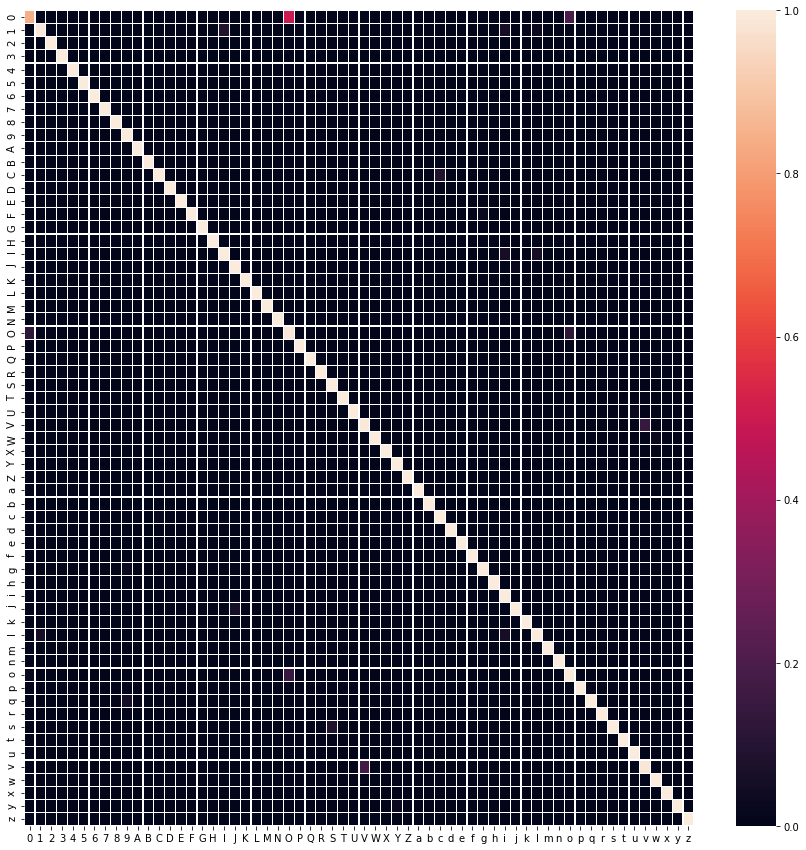

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(model, X, Y)

#Task-2



##Training on 0-9

In [ ]:
X_T2 =train.iloc[:400,1:].values
X_T2 = X_T2.reshape((-1,28,28))
Y_T2 = Y_enc[:400]

In [ ]:

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-1")

In [ ]:
checkpoint_filepath2a = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2a'
model_checkpoint_callback_2a = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2a,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [ ]:
model.fit(X_T2,Y_T2,validation_split=0.01,epochs=200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback_2a])

Epoch 1/200
13/13 [==============================] - 3s 71ms/step - loss: 1.3369 - acc: 0.6717 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 2/200
13/13 [==============================] - 0s 23ms/step - loss: 1.0916 - acc: 0.6793 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 3/200
13/13 [==============================] - 0s 23ms/step - loss: 1.0126 - acc: 0.7121 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 4/200
13/13 [==============================] - 0s 23ms/step - loss: 0.8640 - acc: 0.7525 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 5/200
13/13 [==============================] - 0s 23ms/step - loss: 0.7356 - acc: 0.7803 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 6/200
13/13 [==============================] - 0s 23ms/step - loss: 0.6767 - acc: 0.7854 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 7/200
13/13 [==============================] - 0s 23ms/step - loss: 0.6981 - acc: 0.7929 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 8/200
13/13 [==============================] - 0s 22ms/step - loss: 0.

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2a")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2a/assets


##Convert MNIST data set to CSV format

In [ ]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")
 
    f.read(16)
    l.read(8)
    images = []
 
    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)
 
    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/drive/MyDrive/Colab Notebooks/MIDAS/train-images-idx3-ubyte/train-images.idx3-ubyte", "/content/drive/MyDrive/Colab Notebooks/MIDAS/train-labels-idx1-ubyte/train-labels.idx1-ubyte",
        "/content/drive/MyDrive/Colab Notebooks/MIDAS/mnist_train.csv", 60000)
convert("/content/drive/MyDrive/Colab Notebooks/MIDAS/t10k-images-idx3-ubyte/t10k-images.idx3-ubyte", "/content/drive/MyDrive/Colab Notebooks/MIDAS/train-labels-idx1-ubyte/train-labels.idx1-ubyte",
        "/content/drive/MyDrive/Colab Notebooks/MIDAS/mnist_test.csv", 10000)
 
print("Convert Finished!")


##Load MNIST Data

In [6]:
# load data from csv
mnist_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIDAS/mnist_train.csv",header=None)
mnist_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIDAS/mnist_test.csv",header=None)

In [7]:
pd.unique(mnist_train.iloc[:,0])

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])

In [12]:
mnist_train_x =mnist_train.iloc[:,1:].values
mnist_train_x = mnist_train_x.reshape((-1,28,28))
mnist_train_y = mnist_train.iloc[:,:1].values
mnist_train_y_enc = enc.transform(mnist_train_y.reshape(-1,1)).toarray()

mnist_test_x =mnist_test.iloc[:,1:].values
mnist_test_x = mnist_test_x.reshape((-1,28,28))
mnist_test_y = mnist_test.iloc[:,:1].values
mnist_test_y_enc = enc.transform(mnist_test_y.reshape(-1,1)).toarray()

In [13]:
mnist_train_x.shape, mnist_train_y_enc.shape,mnist_test_x.shape,mnist_test_y_enc.shape,

((60000, 28, 28), (60000, 62), (10000, 28, 28), (10000, 62))

##Pretrained Model Training

In [ ]:
# Load Best Model
model_2b  = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2a")

In [17]:

# CheckPoints
checkpoint_filepath2b = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b'
model_checkpoint_callback_2b = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2b,
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')
# Training
history_2b = model_2b.fit(mnist_train_x,mnist_train_y_enc,validation_data=(mnist_test_x, mnist_test_y_enc),epochs=200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback_2b])

Epoch 1/200
1875/1875 [==============================] - 43s 21ms/step - loss: 1.7365 - acc: 0.6920 - val_loss: 0.3183 - val_acc: 0.9344
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 2/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.4437 - acc: 0.9058 - val_loss: 0.1786 - val_acc: 0.9613
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 3/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2900 - acc: 0.9381 - val_loss: 0.1279 - val_acc: 0.9718
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 4/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2182 - acc: 0.9520 - val_loss: 0.0926 - val_acc: 0.9785
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 5/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1774 - acc: 0.9606 - val_loss: 0.0778 - val_acc: 0.9812
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 6/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1498 - acc: 0.9656 - val_loss: 0.0660 - val_acc: 0.9833
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 7/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1337 - acc: 0.9682 - val_loss: 0.0587 - val_acc: 0.9847
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 8/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1139 - acc: 0.9726 - val_loss: 0.0530 - val_acc: 0.9867
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 9/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1106 - acc: 0.9733 - val_loss: 0.0525 - val_acc: 0.9868
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 10/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0976 - acc: 0.9761 - val_loss: 0.0493 - val_acc: 0.9871
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 11/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0908 - acc: 0.9768 - val_loss: 0.0456 - val_acc: 0.9886
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 12/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0912 - acc: 0.9773 - val_loss: 0.0445 - val_acc: 0.9890
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 13/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0851 - acc: 0.9791 - val_loss: 0.0430 - val_acc: 0.9892
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 14/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0820 - acc: 0.9794 - val_loss: 0.0409 - val_acc: 0.9896
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 15/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0806 - acc: 0.9797 - val_loss: 0.0406 - val_acc: 0.9897
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 16/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0770 - acc: 0.9807 - val_loss: 0.0394 - val_acc: 0.9904
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 17/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0745 - acc: 0.9812 - val_loss: 0.0403 - val_acc: 0.9896
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 18/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0691 - acc: 0.9824 - val_loss: 0.0386 - val_acc: 0.9900
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 19/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0721 - acc: 0.9810 - val_loss: 0.0382 - val_acc: 0.9900
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 20/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0697 - acc: 0.9817 - val_loss: 0.0368 - val_acc: 0.9906
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 21/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0673 - acc: 0.9825 - val_loss: 0.0368 - val_acc: 0.9907
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 22/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0671 - acc: 0.9831 - val_loss: 0.0360 - val_acc: 0.9907
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 23/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0666 - acc: 0.9828 - val_loss: 0.0364 - val_acc: 0.9908
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 24/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0642 - acc: 0.9838 - val_loss: 0.0363 - val_acc: 0.9907
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 25/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0647 - acc: 0.9831 - val_loss: 0.0358 - val_acc: 0.9910
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 26/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0637 - acc: 0.9836 - val_loss: 0.0356 - val_acc: 0.9912
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 27/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0611 - acc: 0.9849 - val_loss: 0.0353 - val_acc: 0.9912
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 28/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0609 - acc: 0.9849 - val_loss: 0.0359 - val_acc: 0.9909
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 29/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0651 - acc: 0.9830 - val_loss: 0.0348 - val_acc: 0.9913
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 30/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0617 - acc: 0.9844 - val_loss: 0.0348 - val_acc: 0.9911
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 31/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0624 - acc: 0.9842 - val_loss: 0.0346 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 32/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0637 - acc: 0.9837 - val_loss: 0.0349 - val_acc: 0.9912
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 33/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0596 - acc: 0.9844 - val_loss: 0.0349 - val_acc: 0.9911
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 34/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0622 - acc: 0.9832 - val_loss: 0.0343 - val_acc: 0.9911
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 35/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0627 - acc: 0.9841 - val_loss: 0.0341 - val_acc: 0.9915
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 36/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0594 - acc: 0.9847 - val_loss: 0.0345 - val_acc: 0.9913
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 37/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0608 - acc: 0.9843 - val_loss: 0.0340 - val_acc: 0.9916
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 38/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0585 - acc: 0.9848 - val_loss: 0.0342 - val_acc: 0.9912
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 39/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0621 - acc: 0.9840 - val_loss: 0.0341 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 40/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0583 - acc: 0.9851 - val_loss: 0.0340 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 41/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0594 - acc: 0.9847 - val_loss: 0.0340 - val_acc: 0.9913
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 42/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0605 - acc: 0.9838 - val_loss: 0.0339 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 43/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0595 - acc: 0.9848 - val_loss: 0.0337 - val_acc: 0.9915
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 44/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0590 - acc: 0.9852 - val_loss: 0.0335 - val_acc: 0.9917
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 45/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0594 - acc: 0.9846 - val_loss: 0.0340 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 46/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0592 - acc: 0.9850 - val_loss: 0.0339 - val_acc: 0.9914
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 47/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0572 - acc: 0.9848 - val_loss: 0.0335 - val_acc: 0.9915
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 48/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0580 - acc: 0.9852 - val_loss: 0.0336 - val_acc: 0.9918
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 49/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0624 - acc: 0.9843 - val_loss: 0.0340 - val_acc: 0.9917
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 50/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0571 - acc: 0.9850 - val_loss: 0.0338 - val_acc: 0.9917
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


Epoch 51/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0617 - acc: 0.9843 - val_loss: 0.0337 - val_acc: 0.9916
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2b/assets


In [18]:
# Save Pretrained Model
model_2b.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2b")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2b/assets


In [19]:
# model_task2 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2b")

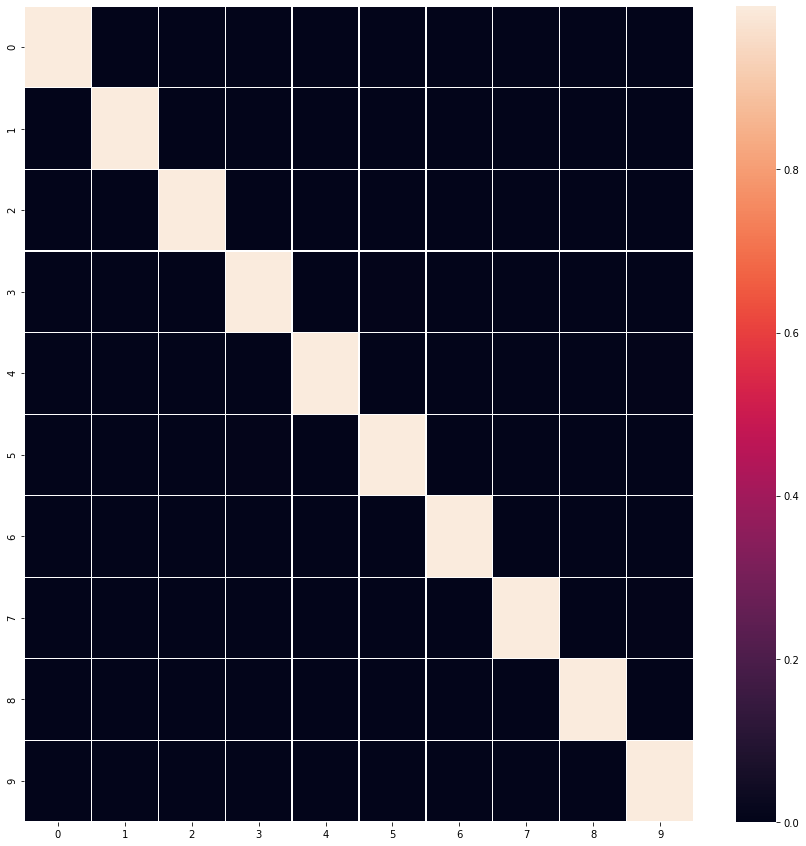

In [20]:
plot_confusion_matrix(model_2b, mnist_test_x, mnist_test_y, lables)

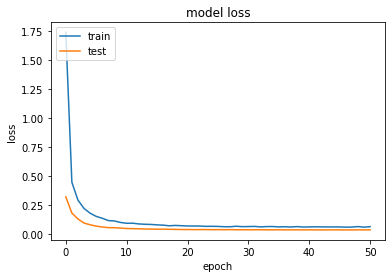

In [21]:
#Training Plot
# summarize history for loss
plt.plot(history_2b.history['loss'])
plt.plot(history_2b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Scratch Model

In [24]:
scratch_model_2c = CNN()
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_filepath2c = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c'
model_checkpoint_callback_2c = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2c,
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')
# compile
scratch_model_2c.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])
history_2c = scratch_model_2c.fit(mnist_train_x,mnist_train_y_enc,validation_data=(mnist_test_x, mnist_test_y_enc),epochs=200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback_2c])

Epoch 1/200
1875/1875 [==============================] - 41s 21ms/step - loss: 0.5915 - acc: 0.8378 - val_loss: 0.0974 - val_acc: 0.9762
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 2/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1204 - acc: 0.9723 - val_loss: 0.0944 - val_acc: 0.9788
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 3/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0885 - acc: 0.9799 - val_loss: 0.0403 - val_acc: 0.9913
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 4/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0791 - acc: 0.9824 - val_loss: 0.0523 - val_acc: 0.9868
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 5/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0687 - acc: 0.9844 - val_loss: 0.0450 - val_acc: 0.9907
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 6/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0524 - acc: 0.9883 - val_loss: 0.0385 - val_acc: 0.9907
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 7/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0409 - acc: 0.9908 - val_loss: 0.0307 - val_acc: 0.9926
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 8/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0297 - acc: 0.9928 - val_loss: 0.0303 - val_acc: 0.9927
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 9/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0271 - acc: 0.9937 - val_loss: 0.0279 - val_acc: 0.9934
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 10/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0233 - acc: 0.9946 - val_loss: 0.0266 - val_acc: 0.9938
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 11/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0202 - acc: 0.9949 - val_loss: 0.0315 - val_acc: 0.9933
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 12/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0172 - acc: 0.9961 - val_loss: 0.0331 - val_acc: 0.9924
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 13/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0141 - acc: 0.9970 - val_loss: 0.0240 - val_acc: 0.9945
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 14/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0119 - acc: 0.9968 - val_loss: 0.0261 - val_acc: 0.9942
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 15/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0106 - acc: 0.9971 - val_loss: 0.0216 - val_acc: 0.9955
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 16/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0078 - acc: 0.9983 - val_loss: 0.0260 - val_acc: 0.9941
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 17/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0069 - acc: 0.9981 - val_loss: 0.0244 - val_acc: 0.9951
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 18/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0080 - acc: 0.9981 - val_loss: 0.0236 - val_acc: 0.9959
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 19/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0244 - val_acc: 0.9952
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 20/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0254 - val_acc: 0.9955
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 21/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.0210 - val_acc: 0.9960
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 22/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0241 - val_acc: 0.9957
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 23/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0231 - val_acc: 0.9959
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 24/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0246 - val_acc: 0.9955
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 25/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0291 - val_acc: 0.9953
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 26/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0263 - val_acc: 0.9954
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 27/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0316 - val_acc: 0.9951
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


Epoch 28/200
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0338 - val_acc: 0.9948
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-2/task-2c/assets


In [25]:
#Save Scrach Trained model
scratch_model_2c.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2c")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2c/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2c/assets


In [26]:
# scratch_model_2c = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-2/task-2c")

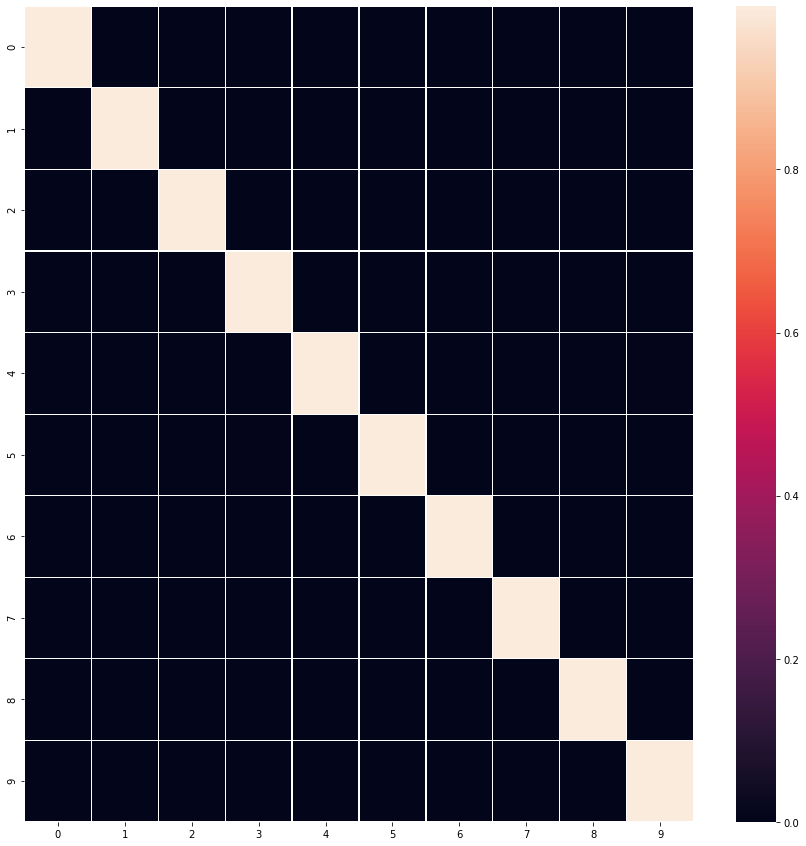

In [27]:
plot_confusion_matrix(scratch_model_2c, mnist_test_x, mnist_test_y, lables)

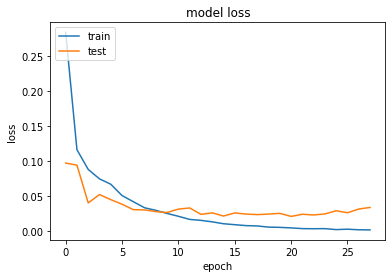

In [28]:
#Training Plot
# summarize history for loss
plt.plot(history_2c.history['loss'])
plt.plot(history_2c.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Observation
Scratch model trains faster 21 epochs in comparision to the pretrained model on 44 epochs and also has better loss in both train and test data than the pretrained model.  
Train data - MNIST Train Set   
Validation data - MNIST Test Set  

*   Pretrained Model(loss: 0.0590 - acc: 0.9852 - val_loss: 0.0335 - val_acc: 0.9917)
*   Scratch Model(loss: 0.0041 - acc: 0.9991 - val_loss: 0.0210 - val_acc: 0.9960)



In [30]:
print(model_2b.evaluate(mnist_test_x, mnist_test_y_enc))
print(scratch_model_2c.evaluate(mnist_test_x, mnist_test_y_enc))

313/313 [==============================] - 2s 7ms/step - loss: 0.0335 - acc: 0.9917
[0.033474694937467575, 0.9916999936103821]
313/313 [==============================] - 2s 7ms/step - loss: 0.0210 - acc: 0.9960
[0.021037708967924118, 0.9959999918937683]


#Task-3 Data


##Load Data

In [ ]:
images = []
def loadMIDAS(path,filenames, lable):
  for f in filenames:
    f = path+"/"+f
    image = [lable]
    copy = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    img = list(copy.flatten())
    image = image + img
    images.append(image)
    
  return 
location = "/content/drive/MyDrive/Colab Notebooks/MIDAS/mnistTask3/mnistTask/"

for id in range(10):
  myPath = location + str(id)
  dump1, dump2, filenames = next(walk(myPath))
  loadMIDAS(myPath, filenames, id)
  print(id)

outf = "/content/drive/MyDrive/Colab Notebooks/MIDAS/task3_train.csv"
o = open(outf, "w")
for image in images:
  o.write(",".join(str(pix) for pix in image)+"\n")
o.close()

In [31]:
train3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIDAS/task3_train.csv", header=None)

In [37]:
# plt.imshow(task3_x[1], cmap=plt.get_cmap('gray'))
task3_x.shape

(60000, 28, 28)

##Lable Encoder

In [32]:
task3_x =train3.iloc[:,1:].values
task3_x = task3_x.reshape((-1,28,28))
task3_y = train3.iloc[:,:1].values
task3_y_enc = enc.transform(task3_y.reshape(-1,1)).toarray()

##Pretrained Model Training

In [ ]:
# Load Best Model of part-1
model_3  = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-1")

In [42]:
checkpoint_filepath3a = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a'
model_checkpoint_callback_3a = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3a,
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')
history_3a = model_3.fit(task3_x,task3_y_enc,validation_data=(mnist_test_x, mnist_test_y_enc),epochs=200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback_3a])

Epoch 1/200
1875/1875 [==============================] - 41s 21ms/step - loss: 5.7102 - acc: 0.0380 - val_loss: 4.1724 - val_acc: 0.0128
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 2/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.9936 - acc: 0.1020 - val_loss: 3.3511 - val_acc: 0.0159
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 3/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.5668 - acc: 0.1078 - val_loss: 3.1174 - val_acc: 0.0138
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 4/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.4531 - acc: 0.1094 - val_loss: 3.0781 - val_acc: 0.0132
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 5/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.4032 - acc: 0.1109 - val_loss: 3.1092 - val_acc: 0.0053
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 6/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3738 - acc: 0.1094 - val_loss: 3.1965 - val_acc: 0.0046
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 7/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3567 - acc: 0.1072 - val_loss: 3.3085 - val_acc: 0.0040
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 8/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3418 - acc: 0.1126 - val_loss: 3.4137 - val_acc: 0.0037
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 9/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3315 - acc: 0.1124 - val_loss: 3.4915 - val_acc: 0.0034
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 10/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3305 - acc: 0.1096 - val_loss: 3.5342 - val_acc: 0.0025
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


Epoch 11/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3232 - acc: 0.1116 - val_loss: 3.6286 - val_acc: 0.0026
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3a/assets


In [43]:
#Save Pretrained model
model_3.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3a")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3a/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3a/assets


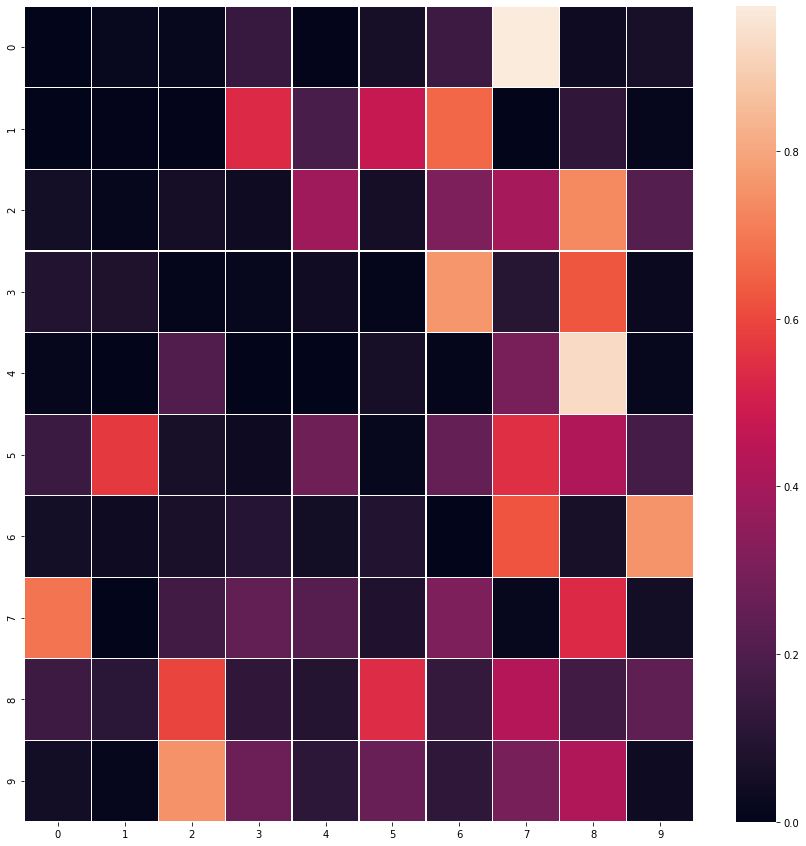

In [44]:
plot_confusion_matrix(model_3, mnist_test_x, mnist_test_y, lables)

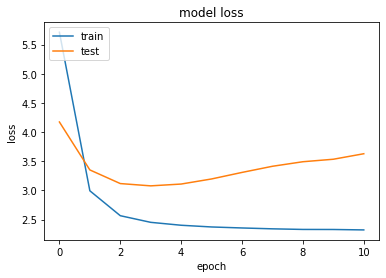

In [45]:
#Training Plot
# summarize history for loss
plt.plot(history_3a.history['loss'])
plt.plot(history_3a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Scratch Model

In [46]:
scratch_model_3 = CNN()
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_filepath3b = '/content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b'
model_checkpoint_callback_3b = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3b,
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')
# compile
scratch_model_3.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])
history_3b = scratch_model_3.fit(task3_x,task3_y_enc,validation_data=(mnist_test_x, mnist_test_y_enc),epochs=200, batch_size = 32,shuffle = True, callbacks = [early_stopper,callback,model_checkpoint_callback_3b])

Epoch 1/200
1875/1875 [==============================] - 41s 21ms/step - loss: 2.4951 - acc: 0.0976 - val_loss: 2.3973 - val_acc: 0.1066
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 2/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3206 - acc: 0.1032 - val_loss: 2.5103 - val_acc: 0.0392
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 3/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.3064 - acc: 0.1040 - val_loss: 2.4782 - val_acc: 0.1021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 4/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.2954 - acc: 0.1073 - val_loss: 2.8639 - val_acc: 0.0144
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 5/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.2883 - acc: 0.1079 - val_loss: 3.3565 - val_acc: 0.0073
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 6/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.2773 - acc: 0.1082 - val_loss: 2.9911 - val_acc: 0.0172
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 7/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.2732 - acc: 0.1103 - val_loss: 3.5154 - val_acc: 0.0047
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


Epoch 8/200
1875/1875 [==============================] - 39s 21ms/step - loss: 2.2599 - acc: 0.1112 - val_loss: 3.3885 - val_acc: 0.0187
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Checkpoints/task-3/task-3b/assets


In [47]:
#Save Scratch model
scratch_model_3.save("/content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3b")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIDAS/Models/task-3/task-3b/assets


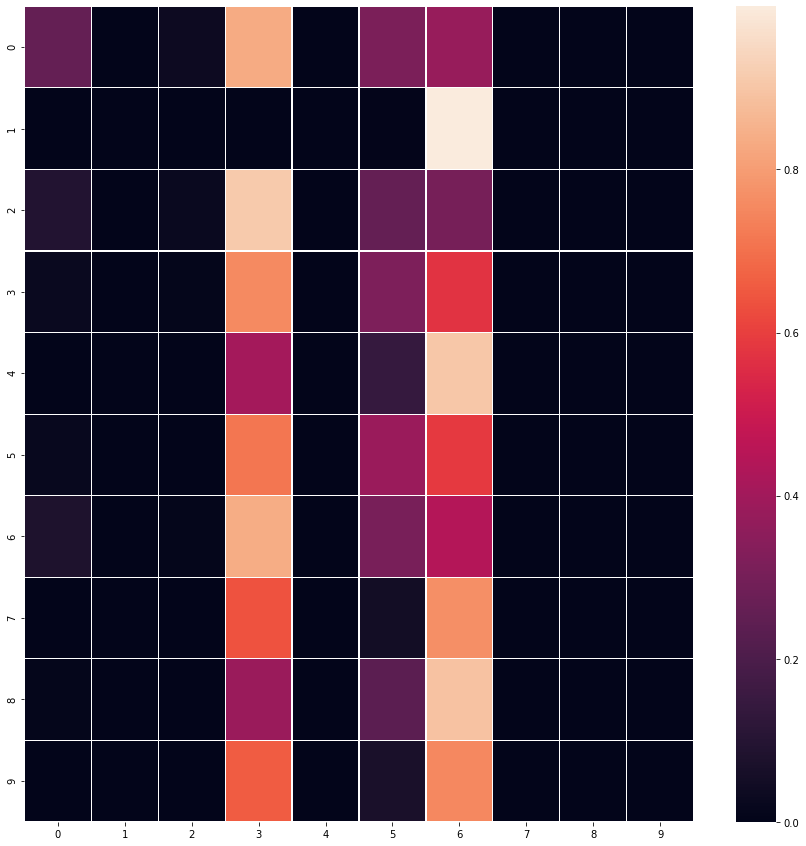

In [48]:
plot_confusion_matrix(scratch_model_3, mnist_test_x, mnist_test_y, lables)

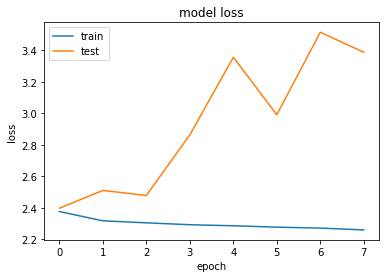

In [49]:
#Training Plot
# summarize history for loss
plt.plot(history_3b.history['loss'])
plt.plot(history_3b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Observation
Scratch model achieved less loss on less number of epochs.   
Train data - task3  
Validation data - MNIST Test Set  

###Pretrained Model
* epochs - 4
* (loss: 2.4531 - acc: 0.1094 - val_loss: 3.0781 - val_acc: 0.0132)
###   Scratch Model
* epochs - 1
* (loss: 2.4951 - acc: 0.0976 - val_loss: 2.3973 - val_acc: 0.1066)



In [50]:
print(model_3.evaluate(mnist_test_x, mnist_test_y_enc))
print(scratch_model_3.evaluate(mnist_test_x, mnist_test_y_enc))

313/313 [==============================] - 2s 7ms/step - loss: 3.0781 - acc: 0.0132
[3.078131675720215, 0.013199999928474426]
313/313 [==============================] - 2s 7ms/step - loss: 2.3973 - acc: 0.1066
[2.397303342819214, 0.10660000145435333]
